In [45]:
import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50

import matplotlib.pyplot as plt
import numpy as np

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

In [47]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

### Load data

In [48]:
img = load_img('data/roboto/img-roboto-2018-08-02 14:15:46.484655.png')
x = img_to_array(img)

/Users/raghotham/code/fontastic/venv/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


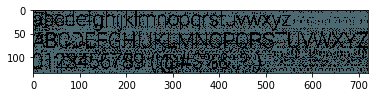

In [49]:
plt.imshow(x/255.)

In [50]:
img_generator = ImageDataGenerator(rotation_range=90.,
                                   featurewise_center=True, 
                                   horizontal_flip=True,
                                   fill_mode='reflect',
                                   vertical_flip=True,
                                   zoom_range=0.4,
                                   featurewise_std_normalization=True,
                                   zca_whitening=False,
                                   width_shift_range=20,
                                   height_shift_range=20,
                                   validation_split=0.2, rescale=1./255)

def get_batches(path, subset, gen=img_generator, 
                shuffle=True, batch_size=8, class_mode='categorical'): 
    return gen.flow_from_directory(path, target_size=(228,228), 
                                   class_mode=class_mode, shuffle=shuffle, batch_size=batch_size, subset=subset)

### Data Augmentation

In [51]:
img = load_img('data/roboto/img-roboto-2018-08-02 14:15:46.484655.png')  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

/Users/raghotham/code/fontastic/venv/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [52]:
!pwd

/Users/raghotham/code/fontastic


In [53]:
# create preview folder

### Transfer Learning with Image Augmentation

In [54]:
from keras.applications import ResNet50

In [74]:
train_generator = get_batches('data/', 'training')
val_generator = get_batches('data/', 'validation')

Found 603 images belonging to 8 classes.
Found 147 images belonging to 8 classes.


In [57]:
base_model = ResNet50(include_top=False, input_shape=(228,228,3))

/Users/raghotham/code/fontastic/venv/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [75]:
batch_size=16

In [82]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(8, activation='softmax')(x)
m = Model(inputs=base_model.input, outputs=predictions)

In [83]:
# m.summary()

In [84]:
# m.compile(loss='categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])

In [88]:
clr_triangular = CyclicLR(base_lr=0.001, max_lr=0.1, mode='triangular', step_size=2*600//batch_size)

m.compile(optimizer='sgd' , loss='categorical_crossentropy', metrics=['accuracy'])


In [89]:
m.fit_generator(
        train_generator,
        steps_per_epoch=600 // batch_size,
        epochs=10,
        callbacks=[clr_triangular],
        validation_data=val_generator,
        validation_steps=140 // batch_size)


Epoch 1/10


/Users/raghotham/code/fontastic/venv/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/Users/raghotham/code/fontastic/venv/lib/python3.6/site-packages/keras_preprocessing/image.py:988: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/raghotham/code/fontastic/venv/lib/python3.6/site-packages/keras_preprocessing/image.py:996: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


14/37 [==========>...................] - ETA: 1:49 - loss: 3.7569 - acc: 0.2470

KeyboardInterrupt: 

In [ ]:

plt.xlabel('Training Iterations' )
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])